In [ ]:
# Установка необходимых пакетов
!pip install pandas numpy nltk pymorphy2 scikit-learn keras imbalanced-learn joblib matplotlib seaborn pymorphy2-dicts-ru


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 86.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b19a7eab4456b15d552ebb67e6daba4188916bf25e4b68fadff6fd0f129cae96
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pandas as pd
import numpy as np
import nltk
import pymorphy2
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from joblib import dump, load
from nltk.corpus import stopwords 
import os
import zipfile

from scipy.sparse import hstack


In [ ]:
# Загрузка необходимых данных NLTK. Эти команды загружают необходимые ресурсы для обработки текста, такие как токенизаторы и стоп-слова.
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def map_okpd2_to_group(code):
    try:
        # Удаляем возможные пробелы и символы
        code = str(code).strip().replace(',', '.')
        code = float(code)
        if code in [41.1, 71.1]:
            return 'ПИР'
        elif code == 43.22:
            return 'Подключение коммуникаций'
        elif 41.0 <= code < 44.0:
            return 'СМР'
        else:
            return 'Прочее'
    except:
        return 'Прочее'

def tokenize_and_lemmatize(text, morph, stop_words):
    # Удаление чисел и специальных символов
    text = re.sub(r'[^а-яА-Я\s]', '', str(text))
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [morph.parse(word)[0].normal_form for word in tokens]
    return ' '.join(tokens)


In [ ]:
def process_large_csv(filepath, chunk_size=100000, desired_total=400000):
    print("Начало обработки большого CSV-файла...")

    # Определяем необходимые переменные
    column_names = ['Index', 'Contract_Number', 'Registry_Number', 'Supplier_INN', 'Supplier_Name', 'Supplier_Address',
                    'Customer_Code', 'Customer_Name', 'Region', 'Another_Code', 'Contract_Status', 'Contract_Type',
                    'Funding_Source', 'Contract_Date', 'Start_Date', 'End_Date', 'Publication_Date', 'Completion_Date',
                    'Empty_1', 'Unknown_Field', 'Empty_2', 'Contract_Value', 'Amount_Paid', 'Contract_Description',
                    'Additional_Info', 'Procurement_Object', 'OKPD2_Code']

    # Инициализация счетчиков для каждого класса
    class_counts = {}
    collected_data = { 'ПИР': [], 'СМР': [], 'Прочее': [] }
    total_classes = ['ПИР', 'СМР', 'Прочее']
    samples_per_class = desired_total // len(total_classes)
    morph = pymorphy2.MorphAnalyzer()
    stop_words = set(stopwords.words('russian'))

    # Чтение CSV-файла по частям
    for chunk in pd.read_csv(filepath, header=None, names=column_names, delimiter=',', on_bad_lines='skip', encoding='utf-8', low_memory=False, chunksize=chunk_size):
        print(f"Обработка нового чанка размером {len(chunk)} строк...")

        # Замена заполнителей на NaN
        chunk.replace({'<НЕ ОПРЕДЕЛЕНО>': np.nan, '': np.nan}, inplace=True)

        # Конвертация столбцов с датами в datetime
        date_columns = ['Contract_Date', 'Start_Date', 'End_Date', 'Publication_Date', 'Completion_Date']
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')

        # Конвертация числовых столбцов
        chunk['Contract_Value'] = pd.to_numeric(chunk['Contract_Value'], errors='coerce')
        chunk['Amount_Paid'] = pd.to_numeric(chunk['Amount_Paid'], errors='coerce')

        # Нормализация текстовых полей
        chunk['Procurement_Object'] = chunk['Procurement_Object'].str.lower().fillna('')
        chunk['Contract_Description'] = chunk['Contract_Description'].str.lower().fillna('')

        # Объединение текстовых полей
        chunk['Full_Description'] = chunk['Procurement_Object'] + ' ' + chunk['Contract_Description']

        # Классификация по кодам ОКПД-2
        chunk['Group'] = chunk['OKPD2_Code'].apply(map_okpd2_to_group)

        # Токенизация и лемматизация текста
        chunk['Processed_Text'] = chunk['Full_Description'].apply(
            lambda text: tokenize_and_lemmatize(text, morph, stop_words)
        )

        # Сбор данных по классам
        for class_name in total_classes:
            class_data = chunk[chunk['Group'] == class_name]
            if class_name not in class_counts:
                class_counts[class_name] = 0
            needed = samples_per_class - class_counts[class_name]
            if needed > 0:
                to_collect = min(needed, len(class_data))
                collected_data[class_name].append(class_data.head(to_collect))
                class_counts[class_name] += to_collect
                print(f"Собрано {to_collect} записей для класса '{class_name}'. Всего собрано: {class_counts[class_name]}")

        # Проверка, достигли ли мы нужного количества данных
        if all(count >= samples_per_class for count in class_counts.values()):
            print("Достигнуто необходимое количество данных для каждого класса.")
            break

    # Объединение данных всех классов
    balanced_df = pd.concat([pd.concat(collected_data[class_name]) for class_name in total_classes], ignore_index=True)
    print(f"Форма сбалансированного DataFrame: {balanced_df.shape}")

    # Сохранение сбалансированных данных в CSV
    balanced_df.to_csv('balanced_data.csv', index=False, encoding='utf-8')
    print("Сбалансированные данные сохранены в 'balanced_data.csv'.")

    return balanced_df


In [ ]:
def load_balanced_data(filepath='balanced_data.csv'):
    print("Загрузка сбалансированных данных...")
    df = pd.read_csv(filepath, encoding='utf-8')

    # Убедимся, что даты в формате datetime
    date_columns = ['Contract_Date', 'Start_Date', 'End_Date', 'Publication_Date', 'Completion_Date']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # Обработка числовых столбцов
    df['Contract_Value'] = pd.to_numeric(df['Contract_Value'], errors='coerce')
    df['Amount_Paid'] = pd.to_numeric(df['Amount_Paid'], errors='coerce')

    # Обработка текстовых полей (если необходимо)
    df['Processed_Text'] = df['Processed_Text'].fillna('')

    # Кодирование меток
    le = LabelEncoder()
    df['Group_Label'] = le.fit_transform(df['Group'])
    print(f"Найденные классы: {le.classes_}")

    return df, le


In [ ]:
def vectorize_and_prepare_features(df):
    print("Векторизация обработанного текста с использованием TF-IDF...")
    vectorizer = TfidfVectorizer(max_features=10000)
    X_text = vectorizer.fit_transform(df['Processed_Text'])
    print(f"Векторизация текста завершена. Размерность: {X_text.shape}")

    print("Масштабирование числовых признаков...")
    # Масштабирование числовых признаков
    scaler = StandardScaler()
    df['Contract_Value'] = df['Contract_Value'].fillna(df['Contract_Value'].mean())
    df['Contract_Value_Scaled'] = scaler.fit_transform(df[['Contract_Value']])

    df['Contract_Duration'] = (df['End_Date'] - df['Start_Date']).dt.days
    df['Contract_Duration'] = df['Contract_Duration'].fillna(df['Contract_Duration'].mean())
    df['Contract_Duration_Scaled'] = scaler.fit_transform(df[['Contract_Duration']])

    # Создание матрицы признаков и целевого вектора
    numerical_features = df[['Contract_Value_Scaled', 'Contract_Duration_Scaled']].values
    X = hstack([X_text, numerical_features])
    y = df['Group_Label']
    print(f"Форма матрицы признаков: {X.shape}")
    print(f"Форма целевого вектора: {y.shape}")

    return X, y, vectorizer, scaler


In [ ]:
def split_data(X, y, test_size=0.2, random_state=42):
    print("Разделение данных на обучающую и тестовую выборки...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    print(f"Форма обучающей выборки: {X_train.shape}, форма тестовой выборки: {X_test.shape}")
    return X_train, X_test, y_train, y_test


In [ ]:
def train_models(X_train, y_train):
    # Логистическая регрессия
    print("Обучение модели Логистической Регрессии...")
    lr_model = LogisticRegression(max_iter=1000, n_jobs=-1)
    lr_model.fit(X_train, y_train)
    print("Модель Логистической Регрессии обучена.")

    # Случайный лес
    print("Обучение модели Случайного Леса...")
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    print("Модель Случайного Леса обучена.")

    # SVM
    print("Обучение модели SVM...")
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train, y_train)
    print("Модель SVM обучена.")

    # Нейронная сеть
    print("Обучение нейронной сети...")
    num_classes = len(np.unique(y_train))
    y_train_nn = to_categorical(y_train, num_classes)

    nn_model = Sequential()
    nn_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    nn_model.add(Dropout(0.5))
    nn_model.add(Dense(64, activation='relu'))
    nn_model.add(Dropout(0.5))
    nn_model.add(Dense(num_classes, activation='softmax'))

    nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print("Фитинг нейронной сети...")
    history = nn_model.fit(
        X_train.toarray(), y_train_nn,
        epochs=5, batch_size=128,
        validation_split=0.2, verbose=1
    )
    print("Нейронная сеть обучена.")

    return lr_model, rf_model, svm_model, nn_model, history


In [ ]:
def evaluate_models(models, X_test, y_test, le):
    lr_model, rf_model, svm_model, nn_model = models
    print("Оценка моделей и вывод отчетов по классификации...")

    # Логистическая регрессия
    y_pred_lr = lr_model.predict(X_test)
    print("Logistic Regression Classification Report:")
    print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

    # Случайный лес
    y_pred_rf = rf_model.predict(X_test)
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

    # SVM
    y_pred_svm = svm_model.predict(X_test)
    print("\nSVM Classification Report:")
    print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

    # Нейронная сеть
    y_pred_nn = nn_model.predict(X_test.toarray())
    y_pred_nn_labels = np.argmax(y_pred_nn, axis=1)
    print("\nNeural Network Classification Report:")
    print(classification_report(y_test, y_pred_nn_labels, target_names=le.classes_))

    return y_pred_lr, y_pred_rf, y_pred_svm, y_pred_nn_labels


In [ ]:
def compare_model_accuracies(models, X_test, y_test, history):
    lr_model, rf_model, svm_model, nn_model = models

    print("Сбор метрик моделей для сравнения...")

    models_names = ['Logistic Regression', 'Random Forest', 'SVM', 'Neural Network']
    accuracies = [
        lr_model.score(X_test, y_test),
        rf_model.score(X_test, y_test),
        svm_model.score(X_test, y_test),
        nn_model.evaluate(X_test.toarray(), to_categorical(y_test, nn_model.output_shape[-1]), verbose=0)[1]
    ]

    comparison_df = pd.DataFrame({
        'Model': models_names,
        'Accuracy': accuracies
    })

    print("\nСравнение точности моделей:")
    print(comparison_df)

    return comparison_df


In [ ]:
def visualize_nn_history(history):
    print("Визуализация истории обучения нейронной сети...")

    # Построение графика точности
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
    plt.plot(history.history['val_accuracy'], label='Точность на валидационной выборке')
    plt.title('Точность модели нейронной сети')
    plt.ylabel('Точность')
    plt.xlabel('Эпоха')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Построение графика потерь
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Потери на обучающей выборке')
    plt.plot(history.history['val_loss'], label='Потери на валидационной выборке')
    plt.title('Потери модели нейронной сети')
    plt.ylabel('Потери')
    plt.xlabel('Эпоха')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import zipfile
import os

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Путь к ZIP-архиву
zip_path = "/content/drive/MyDrive/fz.zip"

# Путь для распаковки
extract_path = "/content"

# Распаковка архива
unzip_file(zip_path, extract_path)
print(f"Архив {zip_path} распакован в {extract_path}")

Архив /content/drive/MyDrive/fz.zip распакован в /content


In [ ]:
print("Начало обработки данных...")

# Чтение и обработка большого CSV-файла
balanced_df = process_large_csv('fz.csv', chunk_size=100000, desired_total=400000)



Начало обработки данных...
Начало обработки большого CSV-файла...
Обработка нового чанка размером 100000 строк...
Собрано 370 записей для класса 'ПИР'. Всего собрано: 370
Собрано 1755 записей для класса 'СМР'. Всего собрано: 1755
Собрано 97875 записей для класса 'Прочее'. Всего собрано: 97875
Обработка нового чанка размером 100000 строк...
Собрано 496 записей для класса 'ПИР'. Всего собрано: 866
Собрано 3785 записей для класса 'СМР'. Всего собрано: 5540
Собрано 35458 записей для класса 'Прочее'. Всего собрано: 133333
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 941 записей для класса 'ПИР'. Всего собрано: 1807
Собрано 5192 записей для класса 'СМР'. Всего собрано: 10732
Обработка нового чанка размером 100000 строк...
Собрано 503 записей для класса 'ПИР'. Всего собрано: 2310
Собрано 3178 записей для класса 'СМР'. Всего собрано: 13910
Обработка нового чанка размером 100000 строк...
Собрано 1345 записей для класса 'ПИР'. Всего собрано: 3655
Собрано 11449 записей для класса 'СМР'. Всего собрано: 25359
Обработка нового чанка размером 100000 строк...
Собрано 1238 записей для класса 'ПИР'. Всего собрано: 4893
Собрано 11502 записей для класса 'СМР'. Всего собрано: 36861
Обработка нового чанка размером 100000 строк...
Собрано 701 записей для класса 'ПИР'. Всего собрано: 5594
Собрано 1684 записей для класса 'СМР'. Всего собрано: 38545
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 826 записей для класса 'ПИР'. Всего собрано: 6420
Собрано 2309 записей для класса 'СМР'. Всего собрано: 40854
Обработка нового чанка размером 100000 строк...
Собрано 1098 записей для класса 'ПИР'. Всего собрано: 7518
Собрано 6381 записей для класса 'СМР'. Всего собрано: 47235
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 402 записей для класса 'ПИР'. Всего собрано: 7920
Собрано 2080 записей для класса 'СМР'. Всего собрано: 49315
Обработка нового чанка размером 100000 строк...
Собрано 337 записей для класса 'ПИР'. Всего собрано: 8257
Собрано 1354 записей для класса 'СМР'. Всего собрано: 50669
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 561 записей для класса 'ПИР'. Всего собрано: 8818
Собрано 3343 записей для класса 'СМР'. Всего собрано: 54012
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 405 записей для класса 'ПИР'. Всего собрано: 9223
Собрано 2720 записей для класса 'СМР'. Всего собрано: 56732
Обработка нового чанка размером 100000 строк...
Собрано 476 записей для класса 'ПИР'. Всего собрано: 9699
Собрано 3220 записей для класса 'СМР'. Всего собрано: 59952
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 380 записей для класса 'ПИР'. Всего собрано: 10079
Собрано 2273 записей для класса 'СМР'. Всего собрано: 62225
Обработка нового чанка размером 100000 строк...
Собрано 507 записей для класса 'ПИР'. Всего собрано: 10586
Собрано 2059 записей для класса 'СМР'. Всего собрано: 64284
Обработка нового чанка размером 100000 строк...
Собрано 619 записей для класса 'ПИР'. Всего собрано: 11205
Собрано 2913 записей для класса 'СМР'. Всего собрано: 67197
Обработка нового чанка размером 100000 строк...
Собрано 407 записей для класса 'ПИР'. Всего собрано: 11612
Собрано 3082 записей для класса 'СМР'. Всего собрано: 70279
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 835 записей для класса 'ПИР'. Всего собрано: 12447
Собрано 5408 записей для класса 'СМР'. Всего собрано: 75687
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1047 записей для класса 'ПИР'. Всего собрано: 13494
Собрано 5857 записей для класса 'СМР'. Всего собрано: 81544
Обработка нового чанка размером 100000 строк...
Собрано 1376 записей для класса 'ПИР'. Всего собрано: 14870
Собрано 12742 записей для класса 'СМР'. Всего собрано: 94286
Обработка нового чанка размером 100000 строк...
Собрано 540 записей для класса 'ПИР'. Всего собрано: 15410
Собрано 2725 записей для класса 'СМР'. Всего собрано: 97011
Обработка нового чанка размером 100000 строк...
Собрано 1036 записей для класса 'ПИР'. Всего собрано: 16446
Собрано 6170 записей для класса 'СМР'. Всего собрано: 103181
Обработка нового чанка размером 100000 строк...
Собрано 997 записей для класса 'ПИР'. Всего собрано: 17443
Собрано 4251 записей для класса 'СМР'. Всего собрано: 107432
Обработка нового чанка размером 100000 строк...
Собрано 1240 записей для класса 'ПИР'. Всего собрано: 18683
Собрано 4554 записей для класса 'СМР'. Всего собрано: 111986
Обработка нового чанка размером 100000

<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1528 записей для класса 'ПИР'. Всего собрано: 21978
Собрано 5235 записей для класса 'СМР'. Всего собрано: 133333
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 403 записей для класса 'ПИР'. Всего собрано: 22381
Обработка нового чанка размером 100000 строк...
Собрано 188 записей для класса 'ПИР'. Всего собрано: 22569
Обработка нового чанка размером 100000 строк...
Собрано 430 записей для класса 'ПИР'. Всего собрано: 22999
Обработка нового чанка размером 100000 строк...
Собрано 662 записей для класса 'ПИР'. Всего собрано: 23661
Обработка нового чанка размером 100000 строк...
Собрано 481 записей для класса 'ПИР'. Всего собрано: 24142
Обработка нового чанка размером 100000 строк...
Собрано 517 записей для класса 'ПИР'. Всего собрано: 24659
Обработка нового чанка размером 100000 строк...
Собрано 566 записей для класса 'ПИР'. Всего собрано: 25225
Обработка нового чанка размером 100000 строк...
Собрано 576 записей для класса 'ПИР'. Всего собрано: 25801
Обработка нового чанка размером 100000 строк...
Собрано 709 записей для класса 'ПИР'. Всего собрано: 26510
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 926 записей для класса 'ПИР'. Всего собрано: 27436
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1210 записей для класса 'ПИР'. Всего собрано: 28646
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1386 записей для класса 'ПИР'. Всего собрано: 30032
Обработка нового чанка размером 100000 строк...
Собрано 840 записей для класса 'ПИР'. Всего собрано: 30872
Обработка нового чанка размером 100000 строк...
Собрано 1090 записей для класса 'ПИР'. Всего собрано: 31962
Обработка нового чанка размером 100000 строк...
Собрано 1478 записей для класса 'ПИР'. Всего собрано: 33440
Обработка нового чанка размером 100000 строк...
Собрано 1518 записей для класса 'ПИР'. Всего собрано: 34958
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1358 записей для класса 'ПИР'. Всего собрано: 36316
Обработка нового чанка размером 100000 строк...
Собрано 1684 записей для класса 'ПИР'. Всего собрано: 38000
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1370 записей для класса 'ПИР'. Всего собрано: 39370
Обработка нового чанка размером 100000 строк...
Собрано 683 записей для класса 'ПИР'. Всего собрано: 40053
Обработка нового чанка размером 100000 строк...
Собрано 1293 записей для класса 'ПИР'. Всего собрано: 41346
Обработка нового чанка размером 100000 строк...
Собрано 1527 записей для класса 'ПИР'. Всего собрано: 42873
Обработка нового чанка размером 100000 строк...
Собрано 1101 записей для класса 'ПИР'. Всего собрано: 43974
Обработка нового чанка размером 100000 строк...
Собрано 696 записей для класса 'ПИР'. Всего собрано: 44670
Обработка нового чанка размером 100000 строк...
Собрано 1604 записей для класса 'ПИР'. Всего собрано: 46274
Обработка нового чанка размером 100000 строк...
Собрано 1235 записей для класса 'ПИР'. Всего собрано: 47509
Обработка нового чанка размером 100000 строк...
Собрано 1180 записей для класса 'ПИР'. Всего собрано: 48689
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 674 записей для класса 'ПИР'. Всего собрано: 49363
Обработка нового чанка размером 100000 строк...
Собрано 492 записей для класса 'ПИР'. Всего собрано: 49855
Обработка нового чанка размером 100000 строк...
Собрано 553 записей для класса 'ПИР'. Всего собрано: 50408
Обработка нового чанка размером 100000 строк...
Собрано 800 записей для класса 'ПИР'. Всего собрано: 51208
Обработка нового чанка размером 100000 строк...
Собрано 207 записей для класса 'ПИР'. Всего собрано: 51415
Обработка нового чанка размером 100000 строк...
Собрано 326 записей для класса 'ПИР'. Всего собрано: 51741
Обработка нового чанка размером 100000 строк...
Собрано 209 записей для класса 'ПИР'. Всего собрано: 51950
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 145 записей для класса 'ПИР'. Всего собрано: 52095
Обработка нового чанка размером 100000 строк...
Собрано 521 записей для класса 'ПИР'. Всего собрано: 52616
Обработка нового чанка размером 100000 строк...
Собрано 1121 записей для класса 'ПИР'. Всего собрано: 53737
Обработка нового чанка размером 100000 строк...
Собрано 1084 записей для класса 'ПИР'. Всего собрано: 54821
Обработка нового чанка размером 100000 строк...
Собрано 513 записей для класса 'ПИР'. Всего собрано: 55334
Обработка нового чанка размером 100000 строк...
Собрано 961 записей для класса 'ПИР'. Всего собрано: 56295
Обработка нового чанка размером 100000 строк...
Собрано 1111 записей для класса 'ПИР'. Всего собрано: 57406
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 905 записей для класса 'ПИР'. Всего собрано: 58311
Обработка нового чанка размером 100000 строк...
Собрано 1438 записей для класса 'ПИР'. Всего собрано: 59749
Обработка нового чанка размером 100000 строк...
Собрано 2304 записей для класса 'ПИР'. Всего собрано: 62053
Обработка нового чанка размером 100000 строк...
Собрано 1186 записей для класса 'ПИР'. Всего собрано: 63239
Обработка нового чанка размером 100000 строк...
Собрано 1644 записей для класса 'ПИР'. Всего собрано: 64883
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 949 записей для класса 'ПИР'. Всего собрано: 65832
Обработка нового чанка размером 100000 строк...
Собрано 1264 записей для класса 'ПИР'. Всего собрано: 67096
Обработка нового чанка размером 100000 строк...
Собрано 1867 записей для класса 'ПИР'. Всего собрано: 68963
Обработка нового чанка размером 100000 строк...
Собрано 460 записей для класса 'ПИР'. Всего собрано: 69423
Обработка нового чанка размером 100000 строк...
Собрано 267 записей для класса 'ПИР'. Всего собрано: 69690
Обработка нового чанка размером 100000 строк...
Собрано 784 записей для класса 'ПИР'. Всего собрано: 70474
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 357 записей для класса 'ПИР'. Всего собрано: 70831
Обработка нового чанка размером 100000 строк...
Собрано 1025 записей для класса 'ПИР'. Всего собрано: 71856
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1527 записей для класса 'ПИР'. Всего собрано: 73383
Обработка нового чанка размером 100000 строк...
Собрано 1703 записей для класса 'ПИР'. Всего собрано: 75086
Обработка нового чанка размером 100000 строк...
Собрано 701 записей для класса 'ПИР'. Всего собрано: 75787
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1651 записей для класса 'ПИР'. Всего собрано: 77438
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1306 записей для класса 'ПИР'. Всего собрано: 78744
Обработка нового чанка размером 100000 строк...
Собрано 855 записей для класса 'ПИР'. Всего собрано: 79599
Обработка нового чанка размером 100000 строк...
Собрано 1467 записей для класса 'ПИР'. Всего собрано: 81066
Обработка нового чанка размером 100000 строк...
Собрано 1666 записей для класса 'ПИР'. Всего собрано: 82732
Обработка нового чанка размером 100000 строк...
Собрано 277 записей для класса 'ПИР'. Всего собрано: 83009
Обработка нового чанка размером 100000 строк...
Собрано 321 записей для класса 'ПИР'. Всего собрано: 83330
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 434 записей для класса 'ПИР'. Всего собрано: 83764
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 470 записей для класса 'ПИР'. Всего собрано: 84234
Обработка нового чанка размером 100000 строк...
Собрано 949 записей для класса 'ПИР'. Всего собрано: 85183
Обработка нового чанка размером 100000 строк...
Собрано 724 записей для класса 'ПИР'. Всего собрано: 85907
Обработка нового чанка размером 100000 строк...
Собрано 1210 записей для класса 'ПИР'. Всего собрано: 87117
Обработка нового чанка размером 100000 строк...
Собрано 1087 записей для класса 'ПИР'. Всего собрано: 88204
Обработка нового чанка размером 100000 строк...
Собрано 930 записей для класса 'ПИР'. Всего собрано: 89134
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1750 записей для класса 'ПИР'. Всего собрано: 90884
Обработка нового чанка размером 100000 строк...
Собрано 1046 записей для класса 'ПИР'. Всего собрано: 91930
Обработка нового чанка размером 100000 строк...
Собрано 1521 записей для класса 'ПИР'. Всего собрано: 93451
Обработка нового чанка размером 100000 строк...
Собрано 1161 записей для класса 'ПИР'. Всего собрано: 94612
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1192 записей для класса 'ПИР'. Всего собрано: 95804
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 654 записей для класса 'ПИР'. Всего собрано: 96458
Обработка нового чанка размером 100000 строк...
Собрано 1352 записей для класса 'ПИР'. Всего собрано: 97810
Обработка нового чанка размером 100000 строк...
Собрано 1525 записей для класса 'ПИР'. Всего собрано: 99335
Обработка нового чанка размером 100000 строк...
Собрано 1014 записей для класса 'ПИР'. Всего собрано: 100349
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1366 записей для класса 'ПИР'. Всего собрано: 101715
Обработка нового чанка размером 100000 строк...
Собрано 710 записей для класса 'ПИР'. Всего собрано: 102425
Обработка нового чанка размером 100000 строк...
Собрано 1255 записей для класса 'ПИР'. Всего собрано: 103680
Обработка нового чанка размером 100000 строк...
Собрано 1148 записей для класса 'ПИР'. Всего собрано: 104828
Обработка нового чанка размером 100000 строк...
Собрано 663 записей для класса 'ПИР'. Всего собрано: 105491
Обработка нового чанка размером 100000 строк...
Собрано 977 записей для класса 'ПИР'. Всего собрано: 106468
Обработка нового чанка размером 100000 строк...
Собрано 1558 записей для класса 'ПИР'. Всего собрано: 108026
Обработка нового чанка размером 100000 строк...
Собрано 945 записей для класса 'ПИР'. Всего собрано: 108971
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 881 записей для класса 'ПИР'. Всего собрано: 109852
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1629 записей для класса 'ПИР'. Всего собрано: 111481
Обработка нового чанка размером 100000 строк...
Собрано 1229 записей для класса 'ПИР'. Всего собрано: 112710
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 664 записей для класса 'ПИР'. Всего собрано: 113374
Обработка нового чанка размером 100000 строк...
Собрано 1070 записей для класса 'ПИР'. Всего собрано: 114444
Обработка нового чанка размером 100000 строк...
Собрано 1026 записей для класса 'ПИР'. Всего собрано: 115470
Обработка нового чанка размером 100000 строк...
Собрано 1485 записей для класса 'ПИР'. Всего собрано: 116955
Обработка нового чанка размером 100000 строк...
Собрано 2037 записей для класса 'ПИР'. Всего собрано: 118992
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1070 записей для класса 'ПИР'. Всего собрано: 120062
Обработка нового чанка размером 100000 строк...
Собрано 615 записей для класса 'ПИР'. Всего собрано: 120677
Обработка нового чанка размером 100000 строк...
Собрано 1248 записей для класса 'ПИР'. Всего собрано: 121925
Обработка нового чанка размером 100000 строк...
Собрано 1936 записей для класса 'ПИР'. Всего собрано: 123861
Обработка нового чанка размером 100000 строк...
Собрано 949 записей для класса 'ПИР'. Всего собрано: 124810
Обработка нового чанка размером 100000 строк...
Собрано 1339 записей для класса 'ПИР'. Всего собрано: 126149
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1611 записей для класса 'ПИР'. Всего собрано: 127760
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1059 записей для класса 'ПИР'. Всего собрано: 128819
Обработка нового чанка размером 100000 строк...
Собрано 1689 записей для класса 'ПИР'. Всего собрано: 130508
Обработка нового чанка размером 100000 строк...


<ipython-input-5-fd7acbffb392>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[col] = pd.to_datetime(chunk[col], errors='coerce')


Собрано 1424 записей для класса 'ПИР'. Всего собрано: 131932
Обработка нового чанка размером 100000 строк...
Собрано 610 записей для класса 'ПИР'. Всего собрано: 132542
Обработка нового чанка размером 100000 строк...
Собрано 791 записей для класса 'ПИР'. Всего собрано: 133333
Достигнуто необходимое количество данных для каждого класса.
Форма сбалансированного DataFrame: (399999, 30)
Сбалансированные данные сохранены в 'balanced_data.csv'.
Загрузка сбалансированных данных...


<ipython-input-6-eff808206558>:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, encoding='utf-8')


Найденные классы: ['ПИР' 'Прочее' 'СМР']
Векторизация обработанного текста с использованием TF-IDF...
Векторизация текста завершена. Размерность: (399999, 376)
Масштабирование числовых признаков...


NameError: name 'hstack' is not defined

In [ ]:
# Загрузка и подготовка сбалансированных данных
df, le = load_balanced_data('balanced_data.csv')

# Векторизация текста и подготовка признаков
X, y, vectorizer, scaler = vectorize_and_prepare_features(df)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)

# Обучение моделей
models = train_models(X_train, y_train)
lr_model, rf_model, svm_model, nn_model, history = models

# Оценка моделей
predictions = evaluate_models([lr_model, rf_model, svm_model, nn_model], X_test, y_test, le)



Загрузка сбалансированных данных...


<ipython-input-6-eff808206558>:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, encoding='utf-8')


Найденные классы: ['ПИР' 'Прочее' 'СМР']
Векторизация обработанного текста с использованием TF-IDF...
Векторизация текста завершена. Размерность: (399999, 376)
Масштабирование числовых признаков...
Форма матрицы признаков: (399999, 378)
Форма целевого вектора: (399999,)
Разделение данных на обучающую и тестовую выборки...
Форма обучающей выборки: (319999, 378), форма тестовой выборки: (80000, 378)
Обучение модели Логистической Регрессии...
Модель Логистической Регрессии обучена.
Обучение модели Случайного Леса...
Модель Случайного Леса обучена.
Обучение модели SVM...
Модель SVM обучена.
Обучение нейронной сети...
Фитинг нейронной сети...
Epoch 1/5
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0848 - accuracy: 0.9726 - val_loss: 0.0494 - val_accuracy: 0.9818
Epoch 2/5
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0530 - accuracy: 0.9800 - val_loss: 0.0486 - val_accuracy: 0.9819
Epoch 3/5
2000/2000 [==============================] - 7s 3ms/step -

NameError: name 'plot_confusion_matrix_custom' is not defined

Построение матриц неточностей для моделей...


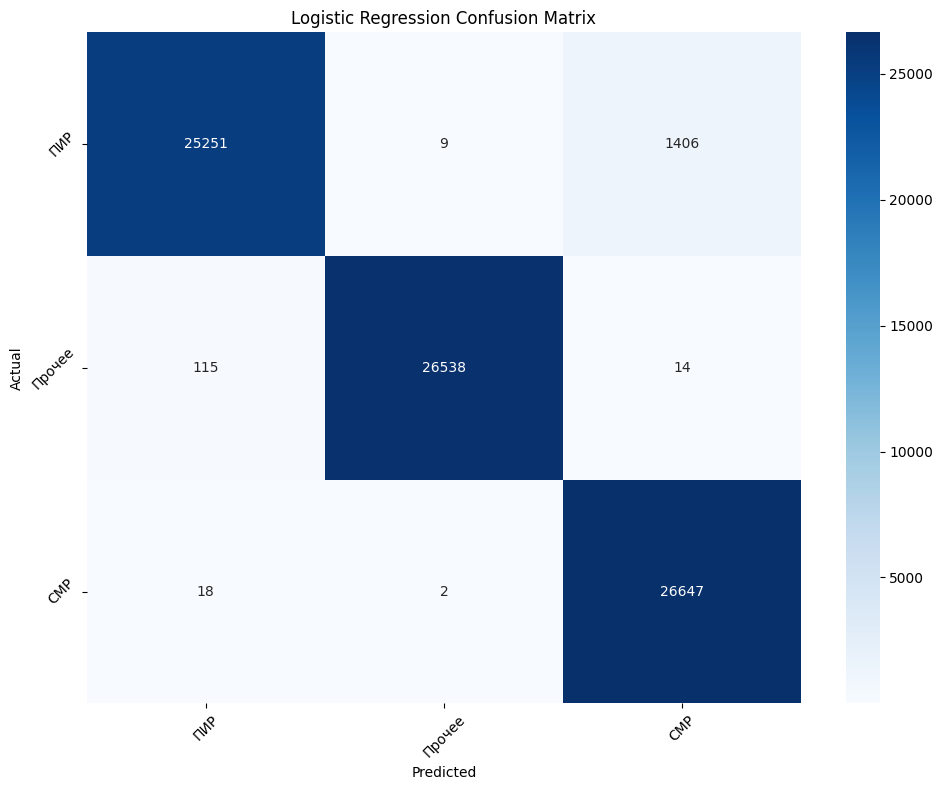

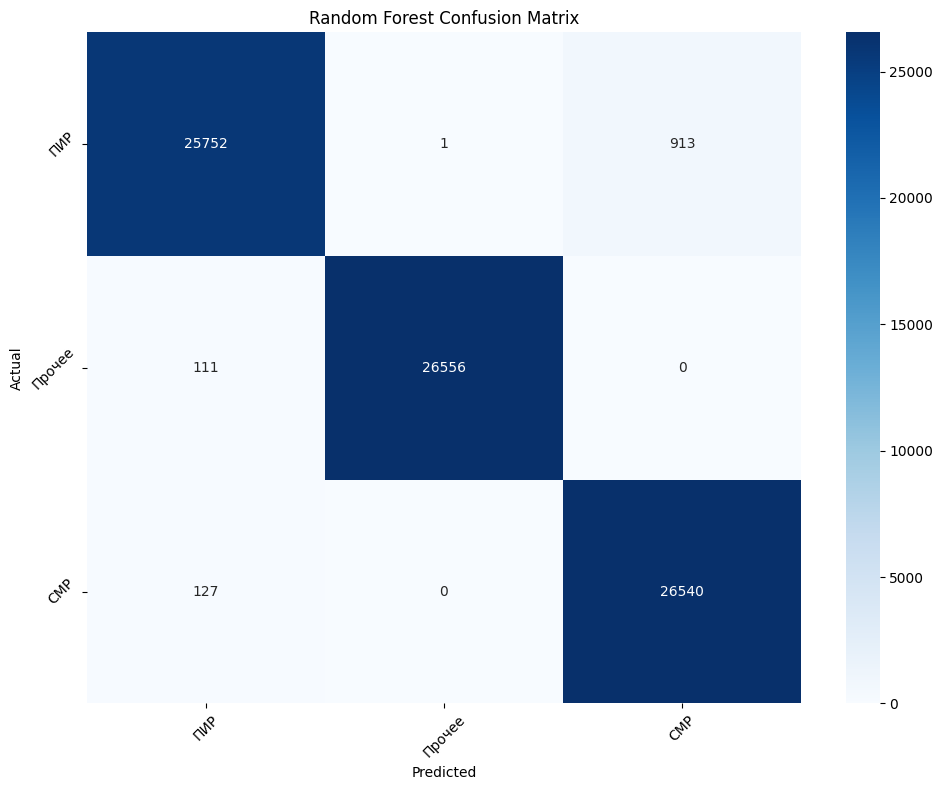

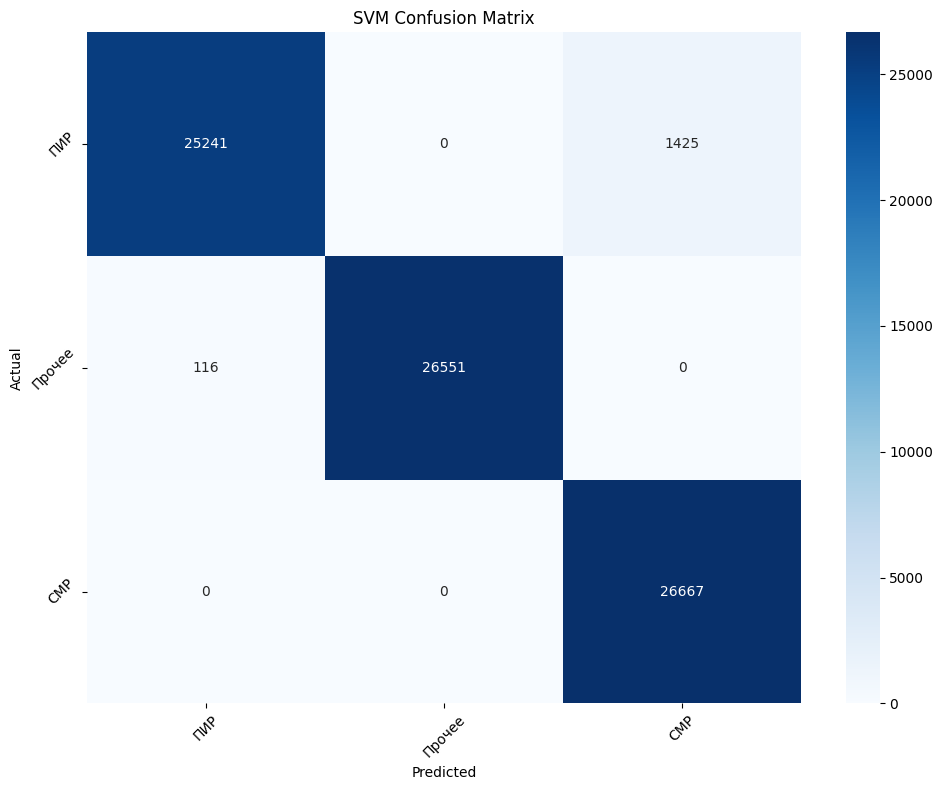

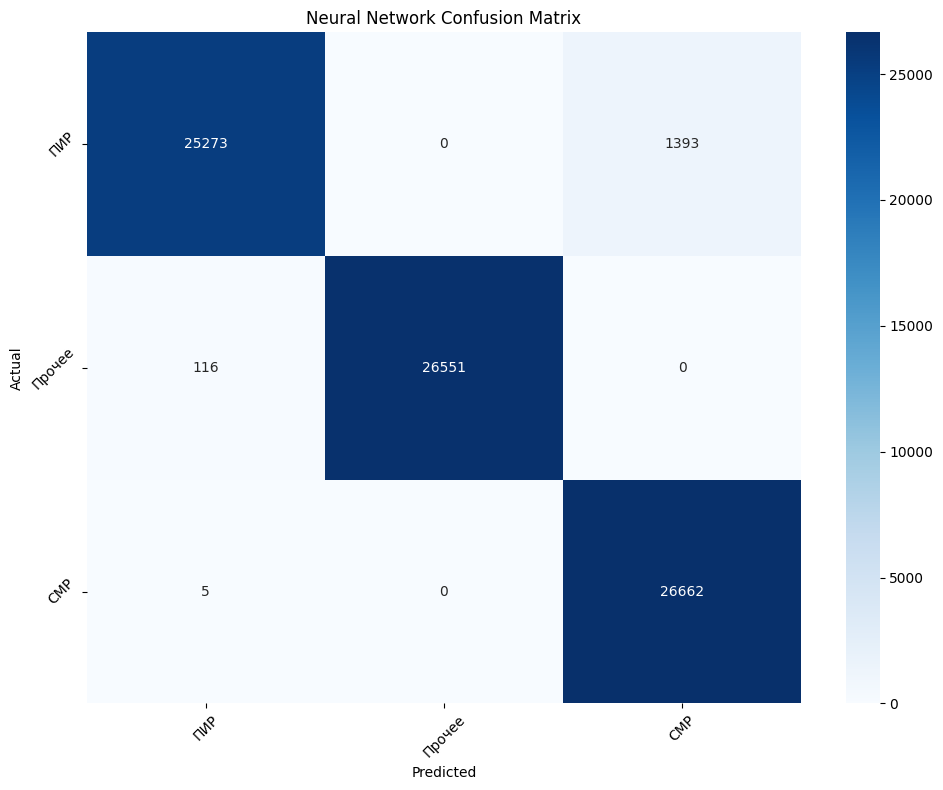

Сбор метрик моделей для сравнения...

Сравнение точности моделей:
                 Model  Accuracy
0  Logistic Regression  0.980450
1        Random Forest  0.985600
2                  SVM  0.980738
3       Neural Network  0.981075
Визуализация истории обучения нейронной сети...


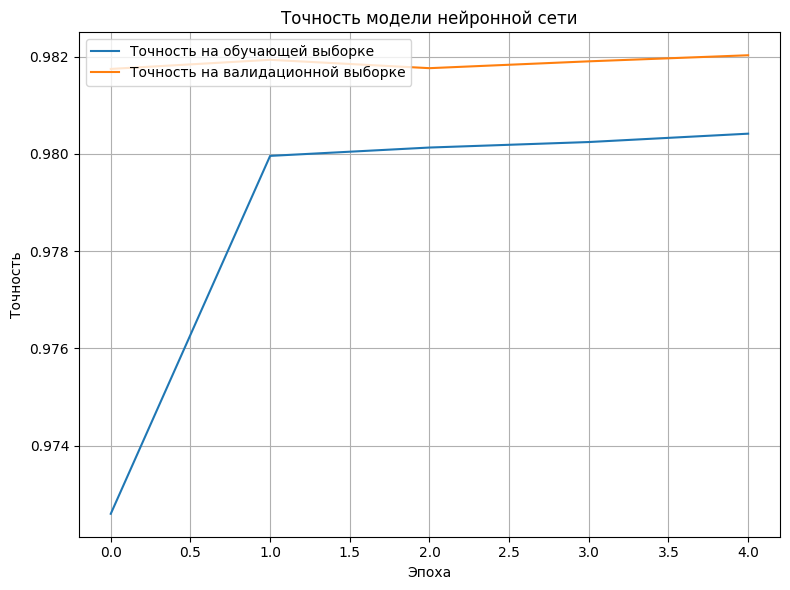

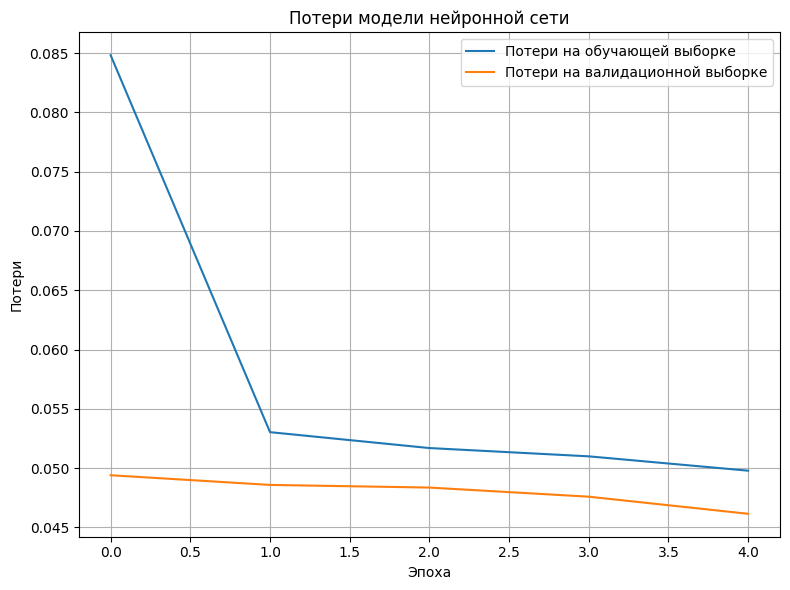

Сохранение моделей и объектов...
Сохранен logistic_regression_model.joblib
Сохранен random_forest_model.joblib
Сохранен svm_model.joblib
Сохранен neural_network_model.h5
Сохранен tfidf_vectorizer.joblib
Сохранен standard_scaler.joblib
Сохранен label_encoder.joblib
Создание архива моделей и объектов...
Все процессы успешно завершены.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
def plot_confusion_matrices(y_test, predictions, le):
    y_pred_lr, y_pred_rf, y_pred_svm, y_pred_nn_labels = predictions

    print("Построение матриц неточностей для моделей...")

    plot_confusion_matrix_custom(y_test, y_pred_lr, le.classes_, 'Logistic Regression Confusion Matrix')
    plot_confusion_matrix_custom(y_test, y_pred_rf, le.classes_, 'Random Forest Confusion Matrix')
    plot_confusion_matrix_custom(y_test, y_pred_svm, le.classes_, 'SVM Confusion Matrix')
    plot_confusion_matrix_custom(y_test, y_pred_nn_labels, le.classes_, 'Neural Network Confusion Matrix')

def plot_confusion_matrix_custom(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Построение матриц неточностей
plot_confusion_matrices(y_test, predictions, le)

# Сравнение точности моделей
comparison_df = compare_model_accuracies([lr_model, rf_model, svm_model, nn_model], X_test, y_test, history)

# Определение функции классификации контрактов
classify_contract = define_classify_contract_function(
    vectorizer, pymorphy2.MorphAnalyzer(), set(stopwords.words('russian')), le, [lr_model, rf_model, svm_model, nn_model], scaler
)
# Визуализация истории обучения нейронной сети
visualize_nn_history(history)
import os
import zipfile
from joblib import dump

print("Сохранение моделей и объектов...")

# Определяем имена файлов и соответствующие объекты
model_filenames = {
    'random_forest_model.joblib': rf_model,
    'tfidf_vectorizer.joblib': vectorizer,
    'standard_scaler.joblib': scaler,
    'label_encoder.joblib': le
}

# Сохраняем модели и объекты на диск
for filename, model in model_filenames.items():
    if filename.endswith('.joblib'):
        dump(model, filename)
    elif filename.endswith('.h5'):
        model.save(filename)
    print(f"Сохранен {filename}")

print("Создание архива моделей и объектов...")
print("Все процессы успешно завершены.")
